# 数据初始化

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

import warnings
warnings.filterwarnings('ignore')

In [2]:
#读取数据集
file_dir = "./data/yeast_benchmarks/yeast/benchmarks"
#将数据集拼接成一个整体
all_csv_list = os.listdir(file_dir)
for single_csv in all_csv_list:
    single_data_frame = pd.read_csv(os.path.join(file_dir, single_csv))
    if single_csv == all_csv_list[0]:
        all_data_frame = single_data_frame
    else:
        all_data_frame = pd.concat([all_data_frame, single_data_frame], ignore_index=True)

#提取X,y
X_all_data_frame = all_data_frame.loc[:, ['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7']]
y_all_data_frame = all_data_frame.loc[:, ['ground.truth']]
def judge_y(y):
    if y == 'nominal':
        return 0
    else:
        return 1
y_trans = y_all_data_frame['ground.truth'].apply(judge_y)

#数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_all_data_frame, y_trans, test_size=0.5, random_state=19)
#标准化
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
#选取100项数据点用于可视化
scatter_num = 300
#降维
pca_train = PCA(n_components = 2)
pca_train.fit(X_train[:scatter_num])
pca_test = PCA(n_components = 2)
pca_test.fit(X_test[:scatter_num])
X_train_d2 = X_train[:scatter_num].dot(pca_train.components_.T)
X_test_d2 = X_test[:scatter_num].dot(pca_test.components_.T)

# kNN

In [3]:
#kNN
clf_name = 'kNN'
clf = KNN(method='median')

In [4]:
#用训练集训练
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
#评价性能
roc_train = round(roc_auc_score(y_train, y_train_scores), 4)
prn_train = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
roc_test = round(roc_auc_score(y_test, y_test_scores), 4)
prn_test = round(precision_n_scores(y_test, y_test_scores), ndigits=4)

In [5]:
#输出计算得到的roc_auc和precision @ rank n
print("\nOn Train Data:")
print(clf_name,'roc:', roc_train,'precision @ rank n:', prn_train)
print("\nOn Test Data:")
print(clf_name,'roc:', roc_test,'precision @ rank n:', prn_test)


On Train Data:
kNN roc: 0.5 precision @ rank n: 0.0

On Test Data:
kNN roc: 0.4544 precision @ rank n: 0.0736


In [6]:
#初始化绘制散点图所使用的数据点坐标
X_train_groundtruth_d2_0 = X_train_d2[y_train[:scatter_num][:] == 0]
X_train_groundtruth_d2_1 = X_train_d2[y_train[:scatter_num][:] == 1]
X_test_groundtruth_d2_0 = X_test_d2[y_test[:scatter_num][:] == 0]
X_test_groundtruth_d2_1 = X_test_d2[y_test[:scatter_num][:] == 1]
X_train_pred_d2_0 = X_train_d2[y_train_pred[:scatter_num][:] == 0]
X_train_pred_d2_1 = X_train_d2[y_train_pred[:scatter_num][:] == 1]
X_test_pred_d2_0 = X_test_d2[y_test_pred[:scatter_num][:] == 0]
X_test_pred_d2_1 = X_test_d2[y_test_pred[:scatter_num][:] == 1]

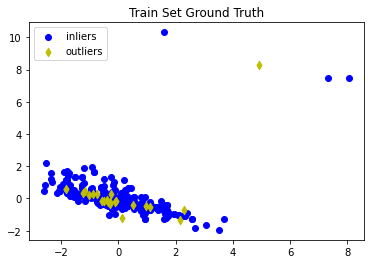

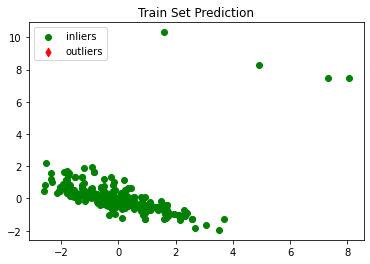

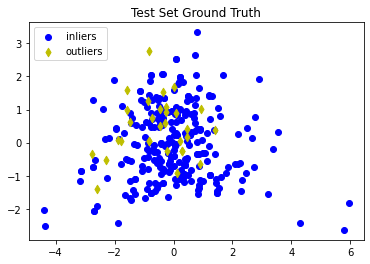

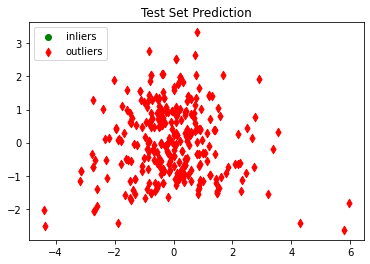

In [7]:
#可视化
plt.scatter(X_train_groundtruth_d2_0[:,0],X_train_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_train_groundtruth_d2_1[:,0],X_train_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Ground Truth')
plt.figure()

plt.scatter(X_train_pred_d2_0[:,0],X_train_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_train_pred_d2_1[:,0],X_train_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Prediction')
plt.figure()

plt.scatter(X_test_groundtruth_d2_0[:,0],X_test_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_test_groundtruth_d2_1[:,0],X_test_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Ground Truth')
plt.figure()

plt.scatter(X_test_pred_d2_0[:,0],X_test_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_test_pred_d2_1[:,0],X_test_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Prediction')
plt.show()

# MCD

In [8]:
#MCD
clf_name = 'MCD'
clf = MCD()

In [9]:
#用训练集训练
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
#评价性能
roc_train = round(roc_auc_score(y_train, y_train_scores), 4)
prn_train = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
roc_test = round(roc_auc_score(y_test, y_test_scores), 4)
prn_test = round(precision_n_scores(y_test, y_test_scores), ndigits=4)

In [10]:
#输出计算得到的roc_auc和precision @ rank n
print("\nOn Train Data:")
print(clf_name,'roc:', roc_train,'precision @ rank n:', prn_train)
print("\nOn Test Data:")
print(clf_name,'roc:', roc_test,'precision @ rank n:', prn_test)


On Train Data:
MCD roc: 0.449 precision @ rank n: 0.0535

On Test Data:
MCD roc: 0.4474 precision @ rank n: 0.0549


In [11]:
#初始化绘制散点图所使用的数据点坐标
X_train_groundtruth_d2_0 = X_train_d2[y_train[:scatter_num][:] == 0]
X_train_groundtruth_d2_1 = X_train_d2[y_train[:scatter_num][:] == 1]
X_test_groundtruth_d2_0 = X_test_d2[y_test[:scatter_num][:] == 0]
X_test_groundtruth_d2_1 = X_test_d2[y_test[:scatter_num][:] == 1]
X_train_pred_d2_0 = X_train_d2[y_train_pred[:scatter_num][:] == 0]
X_train_pred_d2_1 = X_train_d2[y_train_pred[:scatter_num][:] == 1]
X_test_pred_d2_0 = X_test_d2[y_test_pred[:scatter_num][:] == 0]
X_test_pred_d2_1 = X_test_d2[y_test_pred[:scatter_num][:] == 1]

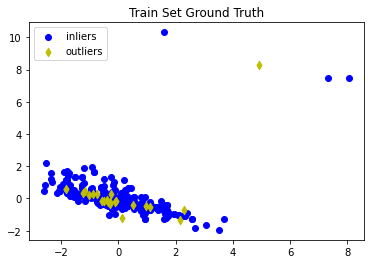

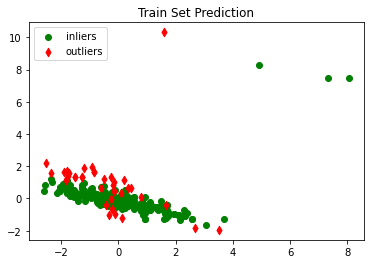

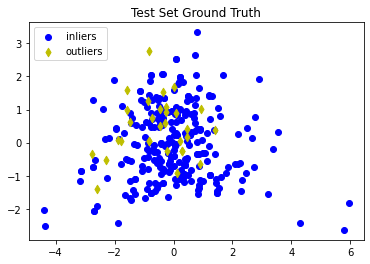

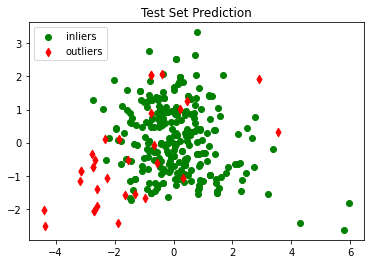

In [12]:
#可视化
plt.scatter(X_train_groundtruth_d2_0[:,0],X_train_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_train_groundtruth_d2_1[:,0],X_train_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Ground Truth')
plt.figure()

plt.scatter(X_train_pred_d2_0[:,0],X_train_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_train_pred_d2_1[:,0],X_train_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Prediction')
plt.figure()

plt.scatter(X_test_groundtruth_d2_0[:,0],X_test_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_test_groundtruth_d2_1[:,0],X_test_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Ground Truth')
plt.figure()

plt.scatter(X_test_pred_d2_0[:,0],X_test_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_test_pred_d2_1[:,0],X_test_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Prediction')
plt.show()

# CBLOF

In [13]:
#CBLOF
clf_name = 'CBLOF'
clf = CBLOF()

In [14]:
#用训练集训练
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
#评价性能
roc_train = round(roc_auc_score(y_train, y_train_scores), 4)
prn_train = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
roc_test = round(roc_auc_score(y_test, y_test_scores), 4)
prn_test = round(precision_n_scores(y_test, y_test_scores), ndigits=4)

In [15]:
#输出计算得到的roc_auc和precision @ rank n
print("\nOn Train Data:")
print(clf_name,'roc:', roc_train,'precision @ rank n:', prn_train)
print("\nOn Test Data:")
print(clf_name,'roc:', roc_test,'precision @ rank n:', prn_test)


On Train Data:
CBLOF roc: 0.4954 precision @ rank n: 0.0756

On Test Data:
CBLOF roc: 0.4971 precision @ rank n: 0.0767


In [16]:
#初始化绘制散点图所使用的数据点坐标
X_train_groundtruth_d2_0 = X_train_d2[y_train[:scatter_num][:] == 0]
X_train_groundtruth_d2_1 = X_train_d2[y_train[:scatter_num][:] == 1]
X_test_groundtruth_d2_0 = X_test_d2[y_test[:scatter_num][:] == 0]
X_test_groundtruth_d2_1 = X_test_d2[y_test[:scatter_num][:] == 1]
X_train_pred_d2_0 = X_train_d2[y_train_pred[:scatter_num][:] == 0]
X_train_pred_d2_1 = X_train_d2[y_train_pred[:scatter_num][:] == 1]
X_test_pred_d2_0 = X_test_d2[y_test_pred[:scatter_num][:] == 0]
X_test_pred_d2_1 = X_test_d2[y_test_pred[:scatter_num][:] == 1]

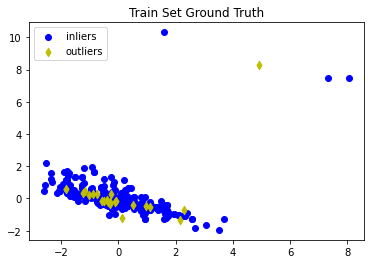

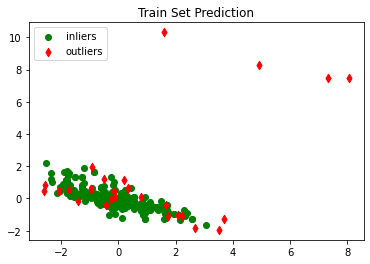

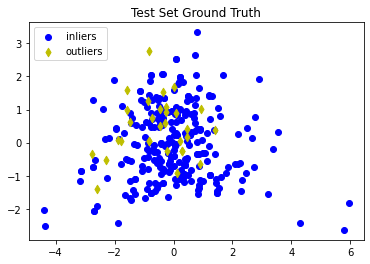

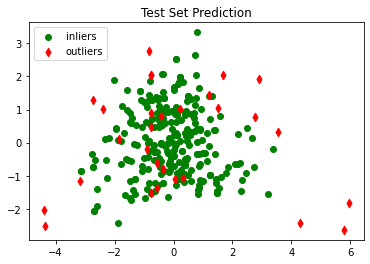

In [17]:
#可视化
plt.scatter(X_train_groundtruth_d2_0[:,0],X_train_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_train_groundtruth_d2_1[:,0],X_train_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Ground Truth')
plt.figure()

plt.scatter(X_train_pred_d2_0[:,0],X_train_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_train_pred_d2_1[:,0],X_train_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Prediction')
plt.figure()

plt.scatter(X_test_groundtruth_d2_0[:,0],X_test_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_test_groundtruth_d2_1[:,0],X_test_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Ground Truth')
plt.figure()

plt.scatter(X_test_pred_d2_0[:,0],X_test_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_test_pred_d2_1[:,0],X_test_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Prediction')
plt.show()

# HBOS

In [18]:
#HBOS
clf_name = 'HBOS'
clf = HBOS()

In [19]:
#用训练集训练
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
#评价性能
roc_train = round(roc_auc_score(y_train, y_train_scores), 4)
prn_train = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
roc_test = round(roc_auc_score(y_test, y_test_scores), 4)
prn_test = round(precision_n_scores(y_test, y_test_scores), ndigits=4)

In [20]:
#输出计算得到的roc_auc和precision @ rank n
print("\nOn Train Data:")
print(clf_name,'roc:', roc_train,'precision @ rank n:', prn_train)
print("\nOn Test Data:")
print(clf_name,'roc:', roc_test,'precision @ rank n:', prn_test)


On Train Data:
HBOS roc: 0.4193 precision @ rank n: 0.1157

On Test Data:
HBOS roc: 0.4231 precision @ rank n: 0.114


In [21]:
#初始化绘制散点图所使用的数据点坐标
X_train_groundtruth_d2_0 = X_train_d2[y_train[:scatter_num][:] == 0]
X_train_groundtruth_d2_1 = X_train_d2[y_train[:scatter_num][:] == 1]
X_test_groundtruth_d2_0 = X_test_d2[y_test[:scatter_num][:] == 0]
X_test_groundtruth_d2_1 = X_test_d2[y_test[:scatter_num][:] == 1]
X_train_pred_d2_0 = X_train_d2[y_train_pred[:scatter_num][:] == 0]
X_train_pred_d2_1 = X_train_d2[y_train_pred[:scatter_num][:] == 1]
X_test_pred_d2_0 = X_test_d2[y_test_pred[:scatter_num][:] == 0]
X_test_pred_d2_1 = X_test_d2[y_test_pred[:scatter_num][:] == 1]

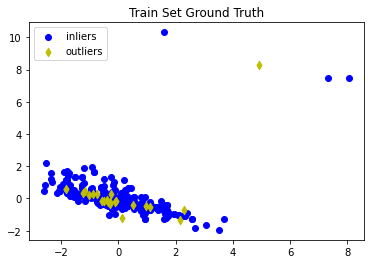

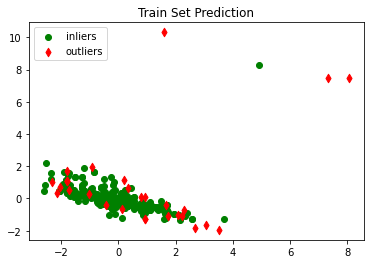

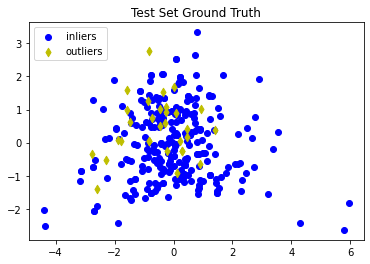

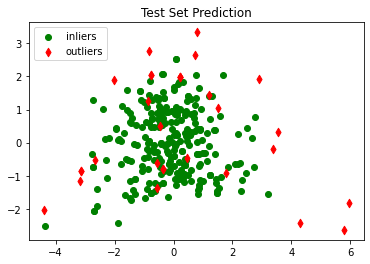

In [22]:
#可视化
plt.scatter(X_train_groundtruth_d2_0[:,0],X_train_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_train_groundtruth_d2_1[:,0],X_train_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Ground Truth')
plt.figure()

plt.scatter(X_train_pred_d2_0[:,0],X_train_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_train_pred_d2_1[:,0],X_train_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Prediction')
plt.figure()

plt.scatter(X_test_groundtruth_d2_0[:,0],X_test_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_test_groundtruth_d2_1[:,0],X_test_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Ground Truth')
plt.figure()

plt.scatter(X_test_pred_d2_0[:,0],X_test_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_test_pred_d2_1[:,0],X_test_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Prediction')
plt.show()

# IForest

In [23]:
#IForest
clf_name = 'IForest'
clf = IForest()

In [24]:
#用训练集训练
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
#评价性能
roc_train = round(roc_auc_score(y_train, y_train_scores), 4)
prn_train = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
roc_test = round(roc_auc_score(y_test, y_test_scores), 4)
prn_test = round(precision_n_scores(y_test, y_test_scores), ndigits=4)

In [25]:
#输出计算得到的roc_auc和precision @ rank n
print("\nOn Train Data:")
print(clf_name,'roc:', roc_train,'precision @ rank n:', prn_train)
print("\nOn Test Data:")
print(clf_name,'roc:', roc_test,'precision @ rank n:', prn_test)


On Train Data:
IForest roc: 0.4198 precision @ rank n: 0.0871

On Test Data:
IForest roc: 0.4202 precision @ rank n: 0.0868


In [26]:
#初始化绘制散点图所使用的数据点坐标
X_train_groundtruth_d2_0 = X_train_d2[y_train[:scatter_num][:] == 0]
X_train_groundtruth_d2_1 = X_train_d2[y_train[:scatter_num][:] == 1]
X_test_groundtruth_d2_0 = X_test_d2[y_test[:scatter_num][:] == 0]
X_test_groundtruth_d2_1 = X_test_d2[y_test[:scatter_num][:] == 1]
X_train_pred_d2_0 = X_train_d2[y_train_pred[:scatter_num][:] == 0]
X_train_pred_d2_1 = X_train_d2[y_train_pred[:scatter_num][:] == 1]
X_test_pred_d2_0 = X_test_d2[y_test_pred[:scatter_num][:] == 0]
X_test_pred_d2_1 = X_test_d2[y_test_pred[:scatter_num][:] == 1]

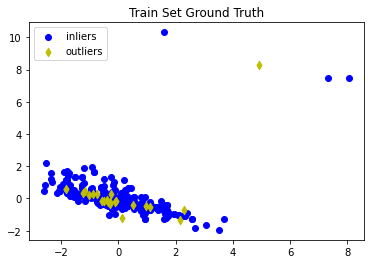

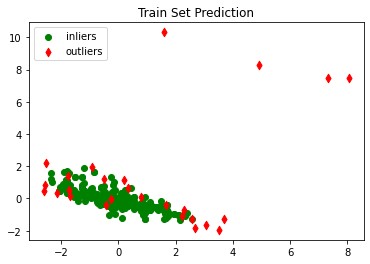

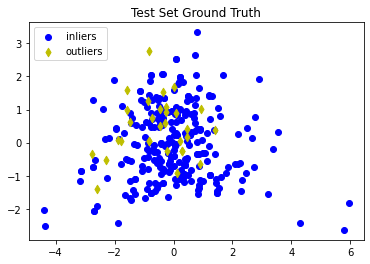

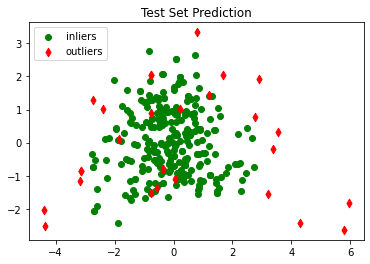

In [27]:
#可视化
plt.scatter(X_train_groundtruth_d2_0[:,0],X_train_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_train_groundtruth_d2_1[:,0],X_train_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Ground Truth')
plt.figure()

plt.scatter(X_train_pred_d2_0[:,0],X_train_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_train_pred_d2_1[:,0],X_train_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Train Set Prediction')
plt.figure()

plt.scatter(X_test_groundtruth_d2_0[:,0],X_test_groundtruth_d2_0[:,1],c='b',marker='o')
plt.scatter(X_test_groundtruth_d2_1[:,0],X_test_groundtruth_d2_1[:,1],c='y',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Ground Truth')
plt.figure()

plt.scatter(X_test_pred_d2_0[:,0],X_test_pred_d2_0[:,1],c='g',marker='o')
plt.scatter(X_test_pred_d2_1[:,0],X_test_pred_d2_1[:,1],c='r',marker='d')
plt.legend((u'inliers', u'outliers'), loc=2)
plt.title('Test Set Prediction')
plt.show()

# 总结分析

In [28]:
#auc的数值大，可以认为分类器在考虑正负样本的综合分类能力的前提下效果更好。
#precision @ rank n的数值大，可以认为分类器在处理前n项数据时的效果更好。
#散点图可以表示出每种分类器的异常检测效果。